<a href="https://colab.research.google.com/github/dangdang2222/skt_ai_fellowship/blob/main/rve_renew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Masking

# keeping the random seed constant from one experiment to the next makes it 
# easier to interpret the effects of hyper-parameters values 
seed = 99
random.seed(seed)
tf.random.set_seed(seed)

def create_model(timesteps, input_dim, intermediate_dim, batch_size, latent_dim, epochs, optimizer):
	# Setup the network parameters:
	timesteps = timesteps
	input_dim = input_dim
	intermediate_dim = intermediate_dim
	batch_size = batch_size
	latent_dim = latent_dim
	epochs = epochs
	if optimizer == 'adam':
		optimizer = keras.optimizers.Adam(learning_rate=0.0001)
	else:
		print("unimplemented optimizer")
		exit(-1)
	masking_value = -99.

	class Sampling(keras.layers.Layer):
		"""Uses (z_mean, sigma) to sample z, the vector encoding an engine trajetory."""
		def call(self, inputs):
			mu, sigma = inputs
			batch = tf.shape(mu)[0]
			dim = tf.shape(mu)[1]
			epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
			return mu + tf.exp(0.5 * sigma) * epsilon
	
	# ----------------------- Encoder -----------------------
	inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')

	mask = Masking(mask_value=masking_value)(inputs)
	
	# LSTM encoding
	h = Bidirectional(LSTM(intermediate_dim))(mask) 

	# VAE Z layer
	mu = Dense(latent_dim)(h)
	sigma = Dense(latent_dim)(h)

	z = Sampling()([mu, sigma])

	# Instantiate the encoder model:
	encoder = keras.Model(inputs, [z, mu, sigma], name='encoder')
	print(encoder.summary())
	# -------------------------------------------------------
	
	# ----------------------- Regressor --------------------
	reg_latent_inputs = Input(shape=(latent_dim,), name='z_sampling_reg')
	reg_intermediate = Dense(200, activation='tanh')(reg_latent_inputs)
	reg_outputs = Dense(1, name='reg_output')(reg_intermediate)
	# Instantiate the classifier model:
	regressor = keras.Model(reg_latent_inputs, reg_outputs, name='regressor')
	print(regressor.summary())
	# -------------------------------------------------------

	''' uncomment if needed
	# ----------------------- Decoder --------------------
	latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
	h_decoded = RepeatVector(timesteps)(latent_inputs)
	h_decoded = Bidirectional(LSTM(intermediate_dim, return_sequences=True))(h_decoded) 
	# decoded layer
	outputs = LSTM(input_dim, return_sequences=True)(h_decoded) 
	# Instantiate the decoder model:
	decoder = keras.Model(latent_inputs, outputs, name='decoder')
	print(decoder.summary())
	# -------------------------------------------------------
	'''
	
	# -------------------- Wrapper model --------------------
	class RVE(keras.Model):
		def __init__(self, encoder, regressor, decoder=None, **kwargs):
			super(RVE, self).__init__(**kwargs)
			self.encoder = encoder
			self.regressor = regressor
			self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
			self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
			self.reg_loss_tracker = keras.metrics.Mean(name="reg_loss")
			self.decoder = decoder
			if self.decoder!=None:
				self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
			

		@property
		def metrics(self):
			if self.decoder!=None:
				return [
					self.total_loss_tracker,
					self.kl_loss_tracker,
					self.reg_loss_tracker,
					self.reconstruction_loss_tracker
				]
			else:
				return [
					self.total_loss_tracker,
					self.kl_loss_tracker,
					self.reg_loss_tracker,
				]

		def train_step(self, data):
			x, target_x = data
			with tf.GradientTape() as tape:
				# kl loss
				z, mu, sigma = self.encoder(x)
				kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
				kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
				# Regressor
				reg_prediction = self.regressor(z)
				reg_loss = tf.reduce_mean(
					keras.losses.mse(target_x, reg_prediction)
				)
				# Reconstruction
				if self.decoder!=None:
					reconstruction = self.decoder(z)
					reconstruction_loss = tf.reduce_mean(
						keras.losses.mse(x, reconstruction)
					)
					total_loss = kl_loss + reg_loss + reconstruction_loss
					self.reconstruction_loss_tracker.update_state(reconstruction_loss)
				else:
					total_loss = kl_loss + reg_loss
			grads = tape.gradient(total_loss, self.trainable_weights)
			self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
			self.total_loss_tracker.update_state(total_loss)
			self.kl_loss_tracker.update_state(kl_loss)
			self.reg_loss_tracker.update_state(reg_loss)
			return {
				"loss": self.total_loss_tracker.result(),
				"kl_loss": self.kl_loss_tracker.result(),
				"reg_loss": self.reg_loss_tracker.result(),
			}


		def test_step(self, data):
			x, target_x = data

			# kl loss
			z, mu, sigma = self.encoder(x)
			kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
			kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
			# Regressor
			reg_prediction = self.regressor(z)
			reg_loss = tf.reduce_mean(
				keras.losses.mse(target_x, reg_prediction)
			)
			# Reconstruction
			if self.decoder!=None:
				reconstruction = self.decoder(z)
				reconstruction_loss = tf.reduce_mean(
					keras.losses.mse(x, reconstruction)
				)
				total_loss = kl_loss + reg_loss + reconstruction_loss
			else:
				total_loss = kl_loss + reg_loss

			return {
				"loss": total_loss,
				"kl_loss": kl_loss,
				"reg_loss": reg_loss,
			}
	# -------------------------------------------------------

	rve = RVE(encoder, regressor)
	rve.compile(optimizer=optimizer)

	return rve

In [ ]:
import math
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, LambdaCallback


# --------------------------------------- DATA PRE-PROCESSING ---------------------------------------
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = abs(df_op_cond['setting_1'].round())
    df_op_cond['setting_2'] = abs(df_op_cond['setting_2'].round(decimals=2))
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0, drop=True)
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]
        
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]  
        
	
def get_data(dataset, sensors, sequence_length, alpha, threshold):
	# files
	dir_path = './drive/MyDrive/CMaps/'
	train_file = 'train_'+dataset+'.txt'
	test_file = 'test_'+dataset+'.txt'
    # columns
	index_names = ['unit_nr', 'time_cycles']
	setting_names = ['setting_1', 'setting_2', 'setting_3']
	sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
	col_names = index_names + setting_names + sensor_names
    # data readout
	train = pd.read_csv((dir_path+train_file), sep=r'\s+', header=None, 
					 names=col_names)
	test = pd.read_csv((dir_path+test_file), sep=r'\s+', header=None, 
					 names=col_names)
	y_test = pd.read_csv((dir_path+'RUL_'+dataset+'.txt'), sep=r'\s+', header=None, 
					 names=['RemainingUsefulLife'])

    # create RUL values according to the piece-wise target function
	train = add_remaining_useful_life(train)
	train['RUL'].clip(upper=threshold, inplace=True)

    # remove unused sensors
	drop_sensors = [element for element in sensor_names if element not in sensors]

    # scale with respect to the operating condition
	X_train_pre = add_operating_condition(train.drop(drop_sensors, axis=1))
	X_test_pre = add_operating_condition(test.drop(drop_sensors, axis=1))
	X_train_pre, X_test_pre = condition_scaler(X_train_pre, X_test_pre, sensors)

    # exponential smoothing
	X_train_pre= exponential_smoothing(X_train_pre, sensors, 0, alpha)
	X_test_pre = exponential_smoothing(X_test_pre, sensors, 0, alpha)

	# train-val split
	gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
	# generate the train/val for *each* sample -> for that we iterate over the train and val units we want
	# this is a for that iterates only once and in that iterations at the same time iterates over all the values we want,
	# i.e. train_unit and val_unit are not a single value but a set of training/vali units
	for train_unit, val_unit in gss.split(X_train_pre['unit_nr'].unique(), groups=X_train_pre['unit_nr'].unique()): 
		train_unit = X_train_pre['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
		val_unit = X_train_pre['unit_nr'].unique()[val_unit]

		x_train = gen_data_wrapper(X_train_pre, sequence_length, sensors, train_unit)
		y_train = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], train_unit)
		
		x_val = gen_data_wrapper(X_train_pre, sequence_length, sensors, val_unit)
		y_val = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], val_unit)

	# create sequences for test 
	test_gen = (list(gen_test_data(X_test_pre[X_test_pre['unit_nr']==unit_nr], sequence_length, sensors, -99.))
			   for unit_nr in X_test_pre['unit_nr'].unique())
	x_test = np.concatenate(list(test_gen)).astype(np.float32)
	
	return x_train, y_train, x_val, y_val, x_test, y_test['RemainingUsefulLife']
# ---------------------------------------------------------------------------------------------------


# --------------------------------------- TRAINING CALLBACKS  ---------------------------------------
class save_latent_space_viz(Callback):
	def __init__(self, model, data, target):
		self.model = model
		self.data = data
		self.target = target
	
	def on_train_begin(self, logs={}):
		self.best_val_loss = 100000
		
	def on_epoch_end(self, epoch, logs=None):
		encoder = self.model.layers[0]
		if logs.get('val_loss') < self.best_val_loss:
			self.best_val_loss = logs.get('val_loss')
			viz_latent_space(encoder, self.data, self.target, epoch, True, False)
	
def get_callbacks(model, data, target):
	model_callbacks = [
		EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30),
        ModelCheckpoint(filepath='./checkpoints/checkpoint',monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True),
		TensorBoard(log_dir='./logs'),
        save_latent_space_viz(model, data, target)
	]
	return model_callbacks

def viz_latent_space(encoder, data, targets=[], epoch='Final', save=False, show=True):
    z, _, _  = encoder.predict(data)
    # plt.figure(figsize=(8, 10))
    # if len(targets)>0:
    #     plt.scatter(z[:, 0], z[:, 1], c=targets)
    # else:
    #     plt.scatter(z[:, 0], z[:, 1])
    # plt.xlabel('z - dim 1')
    # plt.ylabel('z - dim 2')
    # plt.colorbar()
    # if show:
    #     plt.show()
    # if save:
    #     plt.savefig('./latent_space_epoch'+str(epoch)+'.png')
    return z
# ---------------------------------------------------------------------------------------------------

# ----------------------------------------- FIND OPTIMAL LR  ----------------------------------------
class LRFinder:
    """
    Cyclical LR, code tailored from:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]
# ---------------------------------------------------------------------------------------------------

# --------------------------------------------- RESULTS  --------------------------------------------
def get_model(path):
    saved_VRAE_model = load_model(path, compile=False)
    
    # return encoder, regressor
    return saved_VRAE_model.layers[1], saved_VRAE_model.layers[2]

def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

def score(y_true, y_hat):
  res = 0
  for true, hat in zip(y_true, y_hat):
    subs = hat - true
    if subs < 0:
      res = res + np.exp(-subs/13)[0]-1
    else:
      res = res + np.exp(subs/10)[0]-1
  print("score: ", res)

def results(path, x_train, y_train, x_test, y_test):
    # Get model
    encoder, regressor = get_model(path)
    # Latent space
    train_mu = viz_latent_space(encoder, x_train, y_train)
    test_mu = viz_latent_space(encoder, x_test, y_test)
    # Evaluate
    y_hat_train = regressor.predict(train_mu)
    y_hat_test = regressor.predict(test_mu)

    evaluate(y_train, y_hat_train, 'train')
    evaluate(y_test, y_hat_test, 'test')
    score(y_test, y_hat_test)

In [ ]:
import numpy as np


if __name__ == "__main__":
	# ------------------------------ DATA -----------------------------------
	dataset =  "FD004"
	# sensors to work with: T30, T50, P30, PS30, phi
	sensors =  ['s_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12', 's_13', 's_15', 's_17', 's_20', 's_21']
	# windows length
	sequence_length = 30
	# smoothing intensity
	alpha = 0.1
	# max RUL
	threshold = 125
	
	x_train, y_train, x_val, y_val, x_test, y_test = get_data(dataset, sensors, 
	sequence_length, alpha, threshold)
	# -----------------------------------------------------------------------
	
	# ----------------------------- MODEL -----------------------------------
	timesteps = x_train.shape[1]
	input_dim = x_train.shape[2]
	intermediate_dim = 300
	batch_size = 128
	latent_dim = 2
	epochs = 10000
	optimizer = 'adam'
	
	RVE = create_model(timesteps, 
			input_dim, 
			intermediate_dim, 
			batch_size, 
			latent_dim, 
			epochs, 
			optimizer,
			)
	
	# Callbacks for training
	model_callbacks = get_callbacks(RVE, x_train, y_train)
	# -----------------------------------------------------------------------

	# --------------------------- TRAINING ---------------------------------
	results = RVE.fit(x_train, y_train,
			shuffle=True,
			epochs=epochs,
			batch_size=batch_size,
			validation_data= (x_val, y_val),
			callbacks=model_callbacks, verbose=2)
	# -----------------------------------------------------------------------


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 30, 12)]     0           []                               
                                                                                                  
 masking_2 (Masking)            (None, 30, 12)       0           ['encoder_input[0][0]']          
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 600)         751200      ['masking_2[0][0]']              
 )                                                                                                
                                                                                                  
 dense_6 (Dense)                (None, 2)            1202        ['bidirectional_2[0][0]']  

In [ ]:
	# -------------------------- EVALUATION ---------------------------------
	RVE.load_weights('./checkpoints/checkpoint')
	train_mu = viz_latent_space(RVE.encoder, np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
	test_mu = viz_latent_space(RVE.encoder, x_test, y_test.clip(upper=threshold))
	# Evaluate
	y_hat_train = RVE.regressor.predict(train_mu)
	y_hat_test = RVE.regressor.predict(test_mu)

	evaluate(np.concatenate((y_train, y_val)), y_hat_train, 'train')
	evaluate(y_test, y_hat_test, 'test')
	# -----------------------------------------------------------------------

train set RMSE:13.383293151855469, R2:0.8959036695149591
test set RMSE:27.674225600928413, R2:0.742380442495909


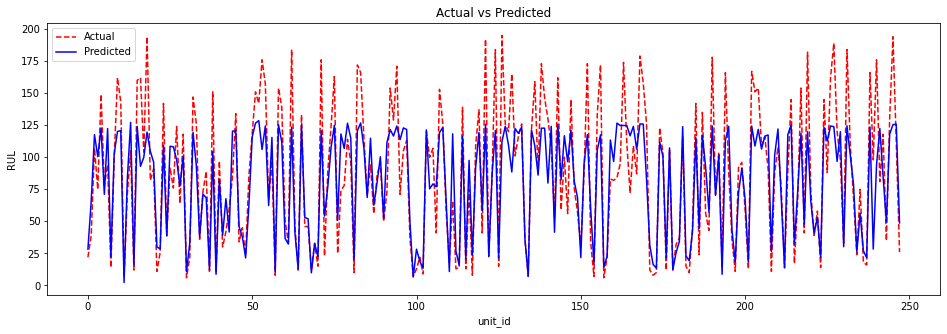

In [ ]:
y_actual = y_test.tolist()
y_pred=y_hat_test.tolist()

index=[]
for i in range (len(y_actual)):
    index.append(i)
    
plt.figure(figsize=(16,5))

plt.plot(index,y_actual,color='red',linestyle='dashed')

plt.plot(index,y_pred,color='blue')

plt.ylabel('RUL')

plt.xlabel('unit_id')

plt.title('Actual vs Predicted')

plt.legend(['Actual','Predicted'])


test set RMSE:41.93194580078125, R2:0.47773614956299015
test set RMSE:28.609722137451172, R2:0.3611580067354333
test set RMSE:49.865013122558594, R2:-1.3788753942744223
test set RMSE:63.56654357910156, R2:-0.5133729079104516
test set RMSE:35.35737609863281, R2:-30.059476571322698
test set RMSE:34.19766616821289, R2:-0.025260631628394314
test set RMSE:19.104164123535156, R2:-6.018636031517616
test set RMSE:47.7158088684082, R2:0.4303256652619778
test set RMSE:127.24200439453125, R2:-1.9879174227799985


ValueError: ignored

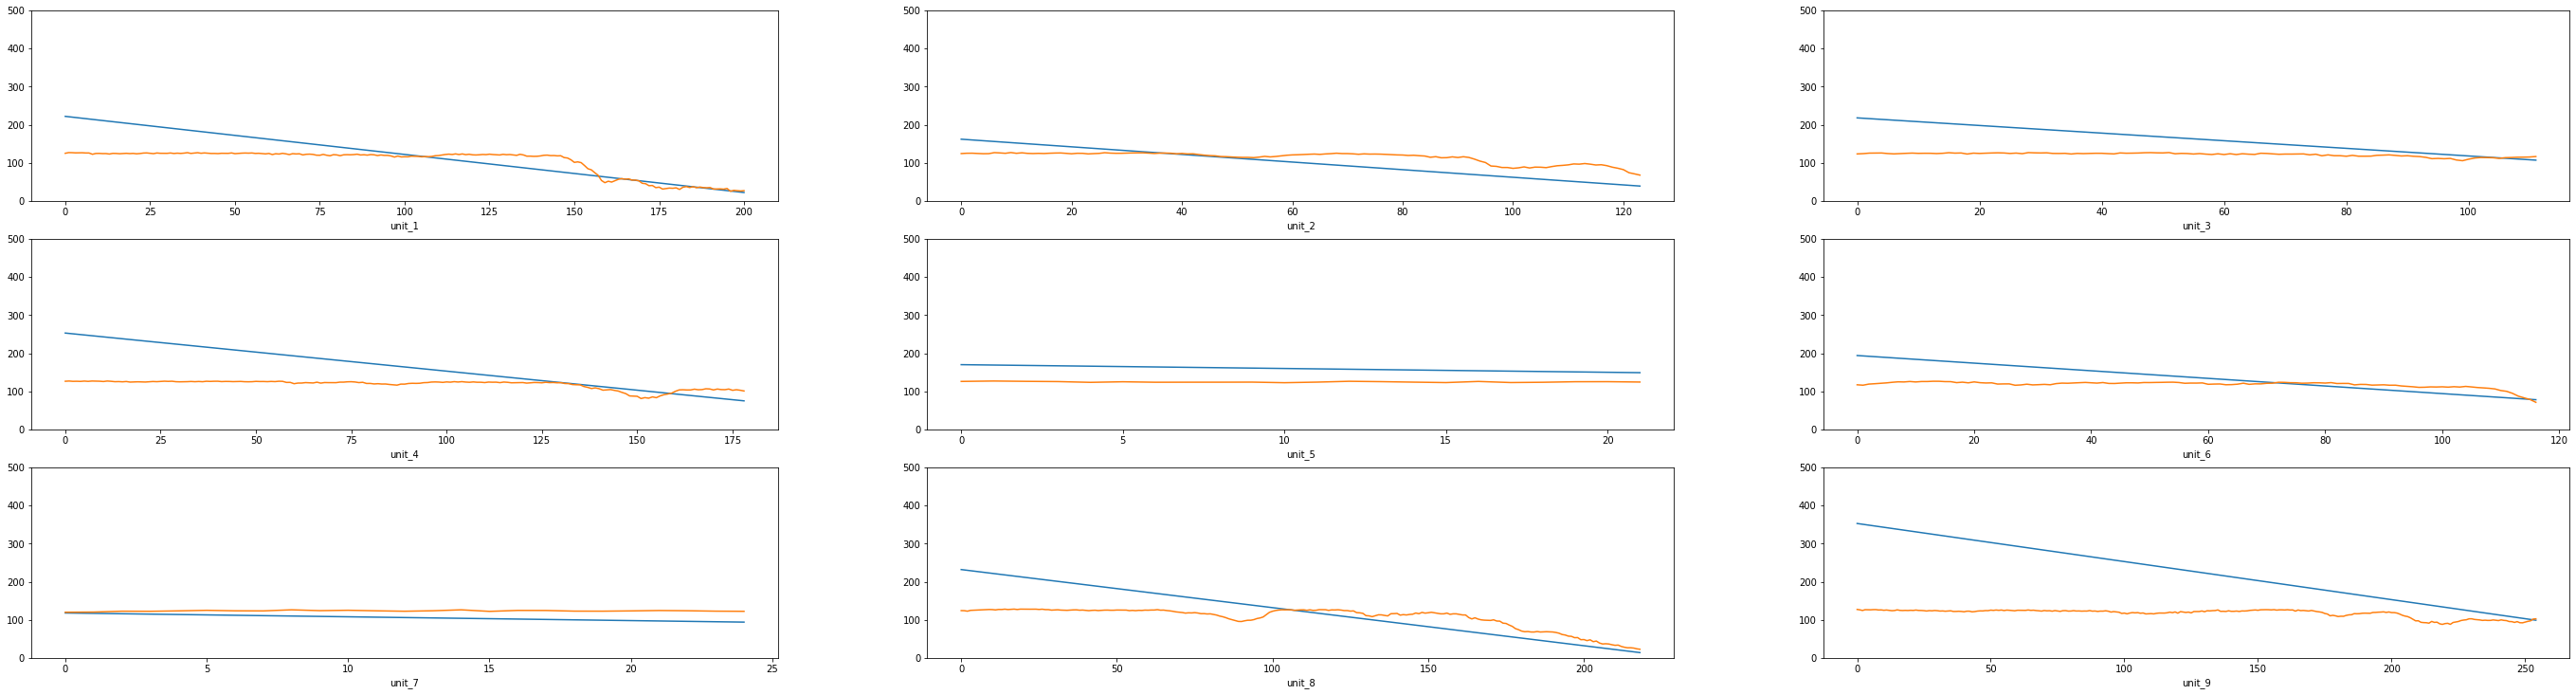

In [ ]:
dir_path = './drive/MyDrive/CMaps/'
train_file = 'train_'+dataset+'.txt'
test_file = 'test_'+dataset+'.txt'
    # columns
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
    # data readout
train = pd.read_csv((dir_path+train_file), sep=r'\s+', header=None, 
					 names=col_names)
test = pd.read_csv((dir_path+test_file), sep=r'\s+', header=None, 
					 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_'+dataset+'.txt'), sep=r'\s+', header=None, 
					 names=['RemainingUsefulLife'])
    # create RUL values according to the piece-wise target function
train = add_remaining_useful_life(train)
train['RUL'].clip(upper=threshold, inplace=True)

our_train = train.copy()
a = test.groupby(by="unit_nr")["time_cycles"].max()
index = a.index
b = y_test['RemainingUsefulLife'].tolist()
bb = pd.Series(b, index);c = a+ bb
result_frame = test.merge(c.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
rruull = result_frame["max_cycle"] - result_frame["time_cycles"]
result_frame["RUL"] = rruull
result_frame = result_frame.drop("max_cycle", axis=1)

drop_sensors = [element for element in sensor_names if element not in sensors]

our_train_pre = add_operating_condition(our_train.drop(drop_sensors, axis=1))
our_test_pre = add_operating_condition(result_frame.drop(drop_sensors, axis=1))
our_train_pre, our_test_pre = condition_scaler(our_train_pre, our_test_pre, sensors)
  
our_train_pre = exponential_smoothing(our_train_pre, sensors, 0 ,alpha)
our_test_pre = exponential_smoothing(our_test_pre, sensors, 0, alpha)

def everything(our_test, our_y,id) : 
  RVE.load_weights('./checkpoints/checkpoint')
  test_mu = viz_latent_space(RVE.encoder, our_test, our_y.clip(max=threshold))
	# Evaluate
  y_hat_test = RVE.regressor.predict(test_mu)

  evaluate(our_y, y_hat_test, 'test')

  y_actual = our_y.tolist()
  y_pred=y_hat_test.tolist()

  index=[]
  for i in range (len(y_actual)):
    index.append(i)
    
  return index, y_actual, y_pred

threshold = 125
plt.figure(figsize=(48,150))
n=1
for id in (our_test_pre['unit_nr'].unique()):
  L = np.array([id])
  our_test = gen_data_wrapper(our_test_pre, sequence_length, sensors, L)
  our_y = gen_label_wrapper(our_test_pre, sequence_length, ['RUL'],L)
  index, y_actual, y_pred = everything(our_test, our_y,id)

  ax = plt.subplot(34,3,n)
  plt.xlabel('unit_'+str(id))
  ax.set_ylim(0,500)
  ax.plot(index,y_actual)
  ax.plot(index,y_pred)
  n+=1

plt.tight_layout()
plt.show()

In [ ]:
dir_path = './drive/MyDrive/CMaps/'
train_file = 'train_'+dataset+'.txt'
test_file = 'test_'+dataset+'.txt'
    # columns
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
    # data readout
train = pd.read_csv((dir_path+train_file), sep=r'\s+', header=None, 
					 names=col_names)
test = pd.read_csv((dir_path+test_file), sep=r'\s+', header=None, 
					 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_'+dataset+'.txt'), sep=r'\s+', header=None, 
					 names=['RemainingUsefulLife'])
    # create RUL values according to the piece-wise target function
train = add_remaining_useful_life(train)
train['RUL'].clip(upper=threshold, inplace=True)

our_train = train.copy()
a = test.groupby(by="unit_nr")["time_cycles"].max()
index = a.index
b = y_test['RemainingUsefulLife'].tolist()
bb = pd.Series(b, index);c = a+ bb
result_frame = test.merge(c.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
rruull = result_frame["max_cycle"] - result_frame["time_cycles"]
result_frame["RUL"] = rruull
result_frame = result_frame.drop("max_cycle", axis=1)

drop_sensors = [element for element in sensor_names if element not in sensors]

our_train_pre = add_operating_condition(our_train.drop(drop_sensors, axis=1))
our_test_pre = add_operating_condition(result_frame.drop(drop_sensors, axis=1))
our_train_pre, our_test_pre = condition_scaler(our_train_pre, our_test_pre, sensors)
  
our_train_pre = exponential_smoothing(our_train_pre, sensors, 0 ,alpha)
our_test_pre = exponential_smoothing(our_test_pre, sensors, 0, alpha)

# for id in (our_test_pre['unit_nr'].unique()):
#   L = np.array([id])
#   our_test = gen_data_wrapper(our_test_pre, sequence_length, sensors, L)
#   our_y = gen_label_wrapper(our_test_pre, sequence_length, ['RUL'],L)
#   index, y_actual, y_pred = everything(our_test, our_y,id)

In [ ]:
our_test_pre[our_test_pre['unit_nr']==10]

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21,RUL,op_cond
1515,10,1,25.0,0.62,60.0,-0.203656,-1.667770,-0.492549,0.293466,0.228709,-0.322304,0.670432,-0.001691,-0.896547,-0.575005,0.545422,-0.287738,184,25.0_0.62_60.0
1516,10,2,10.0,0.25,100.0,-0.789133,-0.725870,-0.656642,0.578326,0.106893,-0.522051,0.607391,-0.066688,-1.051670,-0.332635,0.568827,0.324115,183,10.0_0.25_100.0
1517,10,3,42.0,0.84,100.0,-0.845950,-0.913543,-0.598898,0.557895,0.090347,-0.710697,0.396999,0.030095,-1.164576,-0.108555,0.785518,0.280610,182,42.0_0.84_100.0
1518,10,4,35.0,0.84,100.0,-0.596693,-0.650145,-0.640820,0.624283,0.017532,-0.574021,0.563234,-0.050913,-1.084933,-0.386093,0.724568,0.377797,181,35.0_0.84_100.0
1519,10,5,0.0,0.00,100.0,-0.601348,-0.845989,-0.674028,0.589842,-0.141725,-0.549559,0.542457,-0.028674,-0.940464,-0.245562,0.560465,0.372023,180,0.0_0.0_100.0
1520,10,6,25.0,0.62,60.0,-0.527534,-0.489823,-0.682113,0.559423,-0.103200,-0.607246,0.527460,-0.003801,-0.956871,-0.315871,0.490635,-0.020053,179,25.0_0.62_60.0
1521,10,7,35.0,0.84,100.0,-0.684929,-0.350729,-0.719277,0.541289,-0.121588,-0.647938,0.622547,0.012018,-0.979490,-0.341146,0.677825,0.040940,178,35.0_0.84_100.0
1522,10,8,20.0,0.70,100.0,-0.632621,-0.376523,-0.616261,0.534494,-0.075298,-0.584362,0.581695,0.032946,-0.922724,-0.158527,0.676007,0.238619,177,20.0_0.7_100.0
1523,10,9,10.0,0.25,100.0,-0.687368,-0.410036,-0.598987,0.512170,-0.072465,-0.659383,0.581001,0.015916,-1.003989,-0.151340,0.441077,0.192829,176,10.0_0.25_100.0
1524,10,10,42.0,0.84,100.0,-0.600983,-0.416740,-0.589260,0.439714,-0.071097,-0.567390,0.619602,0.001832,-0.887876,-0.270793,0.524968,0.037682,175,42.0_0.84_100.0


In [ ]:
our_test_pre

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21,RUL,op_cond
0,1,1,20.0,0.70,100.0,-1.291986,-0.371035,-2.446822,-1.269701,-1.611846,-1.804439,-1.255108,-1.670254,0.498634,-1.682168,-1.285619,-0.196676,251,20.0_0.7_100.0
1,1,2,25.0,0.62,60.0,-1.319291,-0.583102,-2.235578,-1.261752,-1.267885,-2.115486,-1.290563,-1.310588,0.226689,-1.099450,-0.404059,-0.178507,250,25.0_0.62_60.0
2,1,3,42.0,0.84,100.0,-1.029485,-1.063450,-2.172079,-1.361982,-0.916181,-1.998272,-1.140364,-1.026640,0.470909,-1.258826,-0.979195,0.217581,249,42.0_0.84_100.0
3,1,4,42.0,0.84,100.0,-0.910432,-1.321252,-2.096013,-1.442700,-0.790000,-1.727776,-1.217803,-0.941823,0.444872,-1.338073,-0.848502,-0.400354,248,42.0_0.84_100.0
4,1,5,35.0,0.84,100.0,-0.921847,-1.440679,-1.878822,-1.440650,-0.912838,-1.797539,-1.231150,-0.950081,0.387552,-1.120656,-0.700182,-0.294075,247,35.0_0.84_100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,42.0,0.84,100.0,1.163527,0.983411,1.085424,-0.529470,0.991865,1.205009,-0.404955,0.983526,1.106291,0.984795,-0.587610,-0.855645,30,42.0_0.84_100.0
41210,248,278,20.0,0.70,100.0,1.179629,1.054594,1.104077,-0.498381,1.004322,1.151275,-0.415745,0.978886,1.129134,0.956208,-0.645923,-0.839880,29,20.0_0.7_100.0
41211,248,279,35.0,0.84,100.0,1.134908,1.041285,1.025245,-0.447348,1.110572,1.200215,-0.427757,1.063386,1.174226,1.000399,-0.724282,-0.868771,28,35.0_0.84_100.0
41212,248,280,20.0,0.70,100.0,1.191251,1.021679,0.997851,-0.499888,1.091671,1.235251,-0.453318,1.069723,1.183347,0.970252,-0.705739,-0.813108,27,20.0_0.7_100.0


In [ ]:
df[df['unit_nr']==unit_nr]